# Team Performance

En este notebook se pretende realizar un análisis del rendimiento de equipo. Algunos de los aspectos que se van a analizar:

   - Pases:
       - Número total de pases y tasa de pases completados.
       - Número de pases en corto y su tasa de pases completados.
       - Número de pases en largo y su tasa de pases completados.
       - Número total de pases al tercio final y su tasa de pases completados.
       - Pases hacia delante.
       - Distancia media de pase.
       - Visualizaciones de las tablas con jugadores y sus estadísticas de pases.
       - Passing network.
       - Visualizaciones de los mapas de calor de los pases realizados.
       - Visualización en la que se muestre la cantidad de pases hecha por cada uno de los equipos.
       - Visualización con las zonas de control de juego.
       
       
   - Finishing actions:
       - Total number of shots.
       - Number of shots on target.
       - Number of shots off target.
       - Number of shots blocked by opponents.
       - Number of shots inside the penalty area.
       - Number of shots outside the penalty area.
       - Number of goals.
       - Number of goals from set-pieces actions.
       - Shot rate per goal.
       - Number of goals inside the penalty area.
       - Number of goals outside the penalty area.
       - Expected goals generated.
       
   - Acciones defensivas:
       - Número de recuperaciones.
       - Número de recuperaciones en campo rival.
       - Número de faltas cometidas.
       - Número de pases del rival en tercio final del campo propio.
       - PPDA (Passes Allowed per Defensive Action) = Passes Allowed / Defensive Actions.
       - Número de tiros del rival.
       - Número de goles concedidos.
       - Expected goals del rival.
       - Visualizaciones de los mapas de calor de los tiros y goles de los rivales.
       - Visualizaciones de los mapas de calor de los pases de los rivales.

In [1]:
#importando paquetes necesarios para visualizar y manipular datos
from statsbombpy import sb
import pandas as pd
import numpy as np
from mplsoccer import VerticalPitch,Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as ticker
from scipy import stats
import json
from PIL import Image
import urllib


import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
pd.options.display.max_rows = 80

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Importar datos

Aquí se accede a la API de StatsBomb para obtneer los datos con los que se realizará el análisis.

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 20
#Tabla de las competiciones abiertas de StatsBomb
free_comps = sb.competitions()
free_comps.competition_name.unique()

array(['1. Bundesliga', 'Champions League', 'Copa del Rey',
       "FA Women's Super League", 'FIFA U20 World Cup', 'FIFA World Cup',
       'Indian Super league', 'La Liga', 'Liga Profesional', 'Ligue 1',
       'Major League Soccer', 'North American League', 'NWSL',
       'Premier League', 'Serie A', 'UEFA Euro', 'UEFA Europa League',
       "UEFA Women's Euro", "Women's World Cup"], dtype=object)

Se obtienen los datos correspondientes a las siguientes competiciones:

    - LaLiga 2015/16: competition_id:11 y season_id:27.
    - Serie A 2015/16: competition_id:12 y season_id:27.
    - Premier League 2015/16: competition_id:2 y season_id:27.
    - Bundesliga 2015/16: competition_id:9 y season_id: 27.

In [3]:
## De esta amnera se pueden obtener todos los eventos de una temporada.
dfSpain = sb.competition_events(    
    country="Spain",
    division= "La Liga",
    season="2015/2016",
    gender="male")

dfSpainMatches = sb.matches(competition_id=11, season_id=27)
dfSpain = dfSpain.merge(dfSpainMatches, on='match_id', how='left')

dfItaly = sb.competition_events(    
    country="Italy",
    division= "Serie A",
    season="2015/2016",
    gender="male")

dfItalyMatches = sb.matches(competition_id=12, season_id=27)
dfItaly = dfItaly.merge(dfItalyMatches, on='match_id', how='left')

dfEngland = sb.competition_events(    
    country="England",
    division= "Premier League",
    season="2015/2016",
    gender="male")

dfEnglandMatches = sb.matches(competition_id=2, season_id=27)
dfEngland = dfEngland.merge(dfEnglandMatches, on='match_id', how='left')

dfGermany = sb.competition_events(    
    country="Germany",
    division= "1. Bundesliga",
    season="2015/2016",
    gender="male")

dfGermanyMatches = sb.matches(competition_id=9, season_id=27)
dfGermany = dfGermany.merge(dfGermanyMatches, on='match_id', how='left')


/Users/javiermazario/miniconda3/envs/tfm/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/javiermazario/miniconda3/envs/tfm/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/javiermazario/miniconda3/envs/tfm/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/javiermazario/miniconda3/envs/tfm/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/javiermazario/miniconda3/envs/tfm/lib/python3.11/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/javiermazario/miniconda3/envs/tfm/lib/python3.11/site-packages/stats

# Data Processing

In order to analyze every phase described in the memory (defensive, building, finishing), we are going to process the season df with the aim to have a aclean df for every phase.

## Finishing

With this function we will obtain the statistics related with finishing actions. (Own goals are not included)

In [4]:
def dfStatsShots(df):
    dfShots = df[df['type']=='Shot'].copy()
    dfShots[['shot_x', 'shot_y']] = dfShots['location'].apply(pd.Series)
    dfShots[['shot_end_x', 'shot_end_y', 'shot_end_height']] = dfShots['shot_end_location'].apply(pd.Series)
    dfShots['shot_end_height'] = dfShots['shot_end_height'].fillna(0)

    total_shots = dfShots.groupby(['team'])['team'].count().to_frame()
    total_shots = total_shots.rename(columns={'team': 'total_shots'})
    onTarget = dfShots[(dfShots['shot_outcome']=='Saved')|(dfShots['shot_outcome']=='Saved to Post')|(dfShots['shot_outcome']=='Goal')]
    offTarget = dfShots[(dfShots['shot_outcome']=='Off T')|(dfShots['shot_outcome']=='Saved Off T')]
    post = dfShots[(dfShots['shot_outcome']=='Post')]
    goals = dfShots[(dfShots['shot_outcome']=='Goal') ]
    blocked = dfShots[(dfShots['shot_outcome']=='Blocked')]
    
    total_shots['onTarget'] = onTarget.groupby(['team'])['team'].count().to_frame()
    total_shots['offTarget'] = offTarget.groupby(['team'])['team'].count().to_frame()
    total_shots['post'] = post.groupby(['team'])['team'].count().to_frame()
    total_shots['blocked'] = blocked.groupby(['team'])['team'].count().to_frame()
    total_shots['goals'] = goals.groupby(['team'])['team'].count().to_frame()
    total_shots['xG_total'] = dfShots.groupby(['team'])['shot_statsbomb_xg'].sum().to_frame()
    
    
    total_shots = total_shots.fillna(0)
    total_shots = total_shots.reset_index()
    total_shots[['onTarget', 'offTarget', 'post', 'blocked', 'goals']] = \
    total_shots[['onTarget', 'offTarget', 'post', 'blocked', 'goals']].astype(int)

    total_shots['onTarget_percentage%'] = total_shots['onTarget']/total_shots['total_shots']*100
    total_shots['Shot_to_goal_ratio'] = total_shots['goals']/total_shots['total_shots']*100
    total_shots['Shot_onTarget_to_goal_ratio'] = total_shots['goals']/total_shots['onTarget']*100
    total_shots['xG/shot'] = total_shots['xG_total']/total_shots['total_shots']

    total_shots['MP'] = df.match_week.max()
    total_shots['Sh/90'] = total_shots['total_shots']/df.match_week.max()
    total_shots['SoT/90'] = total_shots['onTarget']/df.match_week.max()
    total_shots = total_shots.sort_values('total_shots', ascending = False).reset_index(drop=True)
    return total_shots

In [5]:
dfItaly.match_week.max()

38

In [6]:
dfShotsSpain = dfStatsShots(dfSpain)
dfShotsItaly = dfStatsShots(dfItaly)
dfShotsGermany = dfStatsShots(dfGermany)
dfShotsEngland = dfStatsShots(dfEngland)

In [7]:
pd.options.display.max_rows = 80
dfMergedShot = pd.concat([dfShotsItaly, dfShotsEngland, dfShotsGermany, dfShotsSpain], axis=0)
dfMergedShot = dfMergedShot.sort_values('total_shots', ascending=False).reset_index(drop=True)
dfMergedShot

team  total_shots  onTarget  offTarget  post  blocked  \
0                Real Madrid          717       287        226    12      151   
1                     Napoli          664       244        239    11      147   
2          Tottenham Hotspur          656       249        188    15      185   
3                  Liverpool          635       203        183    11      215   
4              Bayern Munich          622       258        183    15      124   
5            Manchester City          614       209        189     9      178   
6                   Juventus          608       212        210    14      133   
7                  Barcelona          604       261        184    22      118   
8                    AS Roma          592       213        191    13      135   
9                    Arsenal          583       209        159    12      171   
10                Fiorentina          582       179        200    13      157   
11                  AC Milan          565       180        189    10      150   
12           West Ham United          559       181        186    11      150   
13                   Chelsea          535       172        171     3      169   
14               Inter Milan          530       163        167     7      150   
15               Southampton          527       168        195    11      130   
16            Leicester City          525       179        177     9      134   
17         Borussia Dortmund          524       209        167     7      117   
18                     Lazio          520       145        197     9      138   
19            Rayo Vallecano          501       178        162    11      114   
20                   Everton          498       173        137    11      157   
21                  Sassuolo          495       152        168     5      142   
22                 Wolfsburg          494       186        161     6      100   
23                 Frosinone          492       131        187    11      126   
24             VfB Stuttgart          491       175        147    10      123   
25                    Empoli          489       146        176     6      139   
26                Schalke 04          486       164        160     7      116   
27           Atlético Madrid          483       164        163    16      105   
28          Bayer Leverkusen          480       178        131    17      110   
29           AFC Bournemouth          478       144        156     5      158   
30                    Torino          478       178        157    10      110   
31            Crystal Palace          477       155        157     9      128   
32                     Genoa          473       154        170     5      121   
33                   Sevilla          472       183        158     5       93   
34                  Atalanta          472       143        170     3      113   
35             Hellas Verona          469       143        160     7      126   
36             Real Sociedad          466       159        154    10      112   
37             Athletic Club          465       167        154    13       98   
38    RC Deportivo La Coruña          457       155        161    12       99   
39  Borussia Mönchengladbach          457       190        123    15      107   
40                    Málaga          456       163        157     3      102   
41                   Udinese          454       147        172     9       96   
42                Sunderland          451       147        151     7      130   
43             Werder Bremen          451       140        146     9      125   
44                   Watford          450       139        143     8      140   
45              Swansea City          448       133        140    12      140   
46                Celta Vigo          446       153        149    16      107   
47                Levante UD          443       144        147     9      102   
48                 Sampdoria          439       154    

In [8]:
dfShotsSpain.to_csv('dataFrames/dfShotsSpain.csv', index=False)
dfShotsGermany.to_csv('dataFrames/dfShotsGermany.csv', index=False)
dfShotsItaly.to_csv('dataFrames/dfShotsItaly.csv', index=False)
dfShotsEngland.to_csv('dataFrames/dfShotsEngland.csv', index=False)
dfMergedShot.to_csv('dataFrames/dfMergedShot.csv', index=False)

## Building

With this function we will obtain the statistics related with building actions.

In [9]:
def dfGeneralStatsPass(df):
    pases = df[df['type']=='Pass'].copy()
    pases[['x', 'y']] = pases['location'].apply(pd.Series)
    pases[['pass_end_x', 'pass_end_y']] = pases['pass_end_location'].apply(pd.Series)
    
    #Pase largo: pases cuya dsitancia sea >30 metros y pass_height == High Pass
    #Pase corto: pases cuya dsitancia sea <30 metros y pass_height == Ground Pass
    pases_largo = pases[(pases['pass_length'] > 30) & (pases['pass_height'] == 'High Pass')]
    pases_corto = pases[(pases['pass_length'] < 30) & (pases['pass_height'] == 'Ground Pass')]

    condicion1 = pases["pass_end_x"]>=80
    condicion2 = pases["x"]<80
    pases_f3 = pases.loc[condicion1 & condicion2,:].copy()

    crosses = pases.loc[pases.pass_cross == True]
    
    pases['pass_length_meters'] = pases['pass_length']*0.9144
    average_pass_length = pases.groupby('team')['pass_length_meters'].mean().to_frame()
    average_pass_length = average_pass_length.rename(columns={'pass_length_meters': 'average_pass_length'})
    
    #Se consideran pases completados aquellos cuyo valor de pass_outcome sea null, incompletos para cualquier otro valor.
    completos = pases[pases['pass_outcome'].isnull()]
    incompletos = pases[pases['pass_outcome'].notnull()]
    
    completos_f3 = pases_f3[pases_f3['pass_outcome'].isnull()]
    incompletos_f3 = pases_f3[pases_f3['pass_outcome'].notnull()]
    
    completos_corto = pases_corto[pases_corto['pass_outcome'].isnull()]
    incompletos_corto = pases_corto[pases_corto['pass_outcome'].notnull()]
    
    completos_largo = pases_largo[pases_largo['pass_outcome'].isnull()]
    incompletos_largo = pases_largo[pases_largo['pass_outcome'].notnull()]

    completos_crosses = crosses[crosses['pass_outcome'].isnull()]
    incompletos_crosses = crosses[crosses['pass_outcome'].notnull()]

    pases_df = pases.groupby('team')['type'].count().to_frame()
    pases_df = pases_df.rename(columns={'type': 'total_passes'})
    pases_df['total_completed'] = completos.groupby(['team'])['type'].count().to_frame()
    pases_df['total_uncompleted'] = incompletos.groupby(['team'])['type'].count().to_frame()
    pases_df = pases_df.fillna(0)
    pases_df = pases_df.reset_index()
    pases_df['total_percentage%'] = pases_df['total_completed']/pases_df['total_passes']*100

    corto_df = pases_corto.groupby('team')['type'].count().to_frame()
    corto_df = corto_df.rename(columns={'type': 'short_passes'})
    corto_df['short_completed'] = completos_corto.groupby(['team'])['type'].count().to_frame()
    corto_df['short_uncompleted'] = incompletos_corto.groupby(['team'])['type'].count().to_frame()
    corto_df = corto_df.fillna(0)
    corto_df = corto_df.reset_index()
    corto_df['short_percentage%'] = corto_df['short_completed']/corto_df['short_passes']*100
        
    largo_df = pases_largo.groupby('team')['type'].count().to_frame()
    largo_df = largo_df.rename(columns={'type': 'long_passes'})
    largo_df['long_completed'] = completos_largo.groupby(['team'])['type'].count().to_frame()
    largo_df['long_uncompleted'] = incompletos_largo.groupby(['team'])['type'].count().to_frame()
    largo_df = largo_df.fillna(0)
    largo_df = largo_df.reset_index()
    largo_df['long_percentage%'] = largo_df['long_completed']/largo_df['long_passes']*100

    f3_df = pases_f3.groupby('team')['type'].count().to_frame()
    f3_df = f3_df.rename(columns={'type': 'f3_passes'})
    f3_df['f3_completed'] = completos_f3.groupby(['team'])['type'].count().to_frame()
    f3_df['f3_uncompleted'] = incompletos_f3.groupby(['team'])['type'].count().to_frame()
    f3_df = f3_df.fillna(0)
    f3_df = f3_df.reset_index()
    f3_df['f3_percentage%'] = f3_df['f3_completed']/f3_df['f3_passes']*100

    crosses = crosses.groupby('team')['type'].count().to_frame()
    crosses = crosses.rename(columns={'type': 'crosses'})
    crosses['crosses_completed'] = completos_crosses.groupby(['team'])['type'].count().to_frame()
    crosses['crosses_uncompleted'] = incompletos_crosses.groupby(['team'])['type'].count().to_frame()
    crosses = crosses.fillna(0)
    crosses = crosses.reset_index()
    crosses['crosses_percentage%'] = crosses['crosses_completed']/crosses['crosses']*100

    combined_df = pases_df.merge(f3_df, on='team', how='left')
    combined_df = combined_df.merge(corto_df, on='team', how='left')
    combined_df = combined_df.merge(largo_df, on='team', how='left')
    combined_df = combined_df.merge(average_pass_length, on='team', how='left')
    combined_df = combined_df.merge(crosses, on='team', how='left')
    combined_df['MP'] = df.match_week.max()
    combined_df = combined_df.fillna(0)

    return combined_df

In [10]:
dfPassSpain = dfGeneralStatsPass(dfSpain)
dfPassItaly = dfGeneralStatsPass(dfItaly)
dfPassEngland = dfGeneralStatsPass(dfEngland)
dfPassGermany = dfGeneralStatsPass(dfGermany)


In [11]:
pd.options.display.max_rows = 80
dfMergedPass = pd.concat([dfPassItaly, dfPassEngland, dfPassGermany, dfPassSpain], axis=0)
dfMergedPass = dfMergedPass.sort_values('total_passes', ascending=False).reset_index(drop=True)
dfMergedPass

team  total_passes  total_completed  \
0                     Napoli         26906            22701   
1              Bayern Munich         25862            22515   
2                  Barcelona         25707            22132   
3                 Fiorentina         23775            19968   
4                Real Madrid         23279            19698   
5          Borussia Dortmund         22982            19241   
6                    Arsenal         22709            18758   
7            Manchester City         22340            18168   
8                    AS Roma         21927            17772   
9          Manchester United         21890            17628   
10                  Juventus         21563            17966   
11                 Liverpool         21464            16991   
12                   Chelsea         21275            17277   
13                Las Palmas         21077            16923   
14               Inter Milan         20666            16578   
15         Tottenham Hotspur         20624            16226   
16                Celta Vigo         20611            16210   
17                    Empoli         20181            16203   
18                     Lazio         20150            15571   
19              Swansea City         20003            15867   
20  Borussia Mönchengladbach         19896            15985   
21                   Everton         19868            15843   
22                 Wolfsburg         19671            16100   
23           AFC Bournemouth         19406            15163   
24           Atlético Madrid         19209            14673   
25            Rayo Vallecano         18936            14175   
26                  AC Milan         18933            14725   
27             Real Sociedad         18735            14031   
28                  Sassuolo         18637            14172   
29             Athletic Club         18308            13455   
30                 Sampdoria         18245            14251   
31                  Valencia         18014            13836   
32               Southampton         17995            13530   
33                Stoke City         17878            13778   
34                     Genoa         17706            13368   
35    RC Deportivo La Coruña         17611            12862   
36                   Bologna         17594            13370   
37                Villarreal         17546            13145   
38                  Atalanta         17392            12813   
39                   Sevilla         17372            13002   
40                    Torino         17277            13676   
41               Aston Villa         17168            13015   
42             Hertha Berlin         16959            13253   
43                    Chievo         16891            12416   
44                    Málaga         16807            12064   
45          Newcastle United         16799            12660   
46                Schalke 04         16793            13274   
47           West Ham United         16773            12665   
48              Norwich City         16652            11912   
49                Real Betis         16540            12122   
50             Hellas Verona         16397            11915   
51                   Watford         16362            11598   
52          Bayer Leverkusen         16329            11997   
53                Levante UD         16295            11871   
54                     Eibar         16182            10874   
55                   Udinese         16147            11664   
56                  Espanyol         16128            11793   
57                    Getafe         16080            11860   
58                   Palermo         15919            11669   
59            Crystal Palace         15808            11395   
60            Sporting Gijón         15681            11080   
61              Hamburger SV         15534            11270   
62       Eintracht Frankfurt         15431            1

In [12]:
dfPassSpain.to_csv('dataFrames/dfPassSpain.csv', index=False)
dfPassGermany.to_csv('dataFrames/dfPassGermany.csv', index=False)
dfPassItaly.to_csv('dataFrames/dfPassItaly.csv', index=False)
dfPassEngland.to_csv('dataFrames/dfPassEngland.csv', index=False)
dfMergedPass.to_csv('dataFrames/dfMergedPass.csv', index=False)

In [13]:
from visualization.passing_network import draw_pitch, draw_pass_map
import matplotlib.pyplot as plt

def _statsbomb_to_point(location, max_width=120, max_height=80):
    '''
    Convert a point's coordinates from a StatsBomb's range to 0-1 range.
    '''
    return location[0] / max_width, 1-(location[1] / max_height)

def passing_network_FoT(df, identificador, team_name):
    
    lineups = sb.lineups(match_id=identificador)
    # Extract the DataFrame for the specified team
    team_lineup = lineups[team_name]

    # Create the names_dict by iterating through the DataFrame
    names_dict = {row["player_name"]: row["player_nickname"] for _, row in team_lineup.iterrows()}

    df_events = df[df['match_id']==identificador]
    first_red_card_minute = df_events[df_events.bad_behaviour_card.isin(["Second Yellow", "Red Card"])].minute.min()
    first_substitution_minute = df_events[df_events.type == "Substitution"].minute.min()
    max_minute = df_events.minute.max()

    num_minutes = min(first_substitution_minute, first_red_card_minute, max_minute)

    plot_name = "statsbomb_match{0}_{1}".format(identificador, team_name)

    opponent_team = [x for x in df_events.team.unique() if x != team_name][0]
    plot_title ="{0}'s passing network against {1} (StatsBomb eventing data)".format(team_name, opponent_team)

    plot_legend = "Location: pass origin\nSize: number of passes\nColor: number of passes"

    df_passes = df_events[(df_events.type == "Pass") &
                      (df_events.pass_outcome.isna()) &
                      (df_events.team == team_name) &
                      (df_events.minute < num_minutes)].copy()

    # If available, use player's nickname instead of full name to optimize space in plot
    df_passes["pass_recipient"] = df_passes.pass_recipient.apply(lambda x: names_dict[x] if names_dict[x] else x)
    df_passes["player_name"] = df_passes.player.apply(lambda x: names_dict[x] if names_dict[x] else x)

    df_passes["origin_pos_x"] = df_passes.location.apply(lambda x: _statsbomb_to_point(x)[0])
    df_passes["origin_pos_y"] = df_passes.location.apply(lambda x: _statsbomb_to_point(x)[1])
    player_position = df_passes.groupby("player_name").agg({"origin_pos_x": "median", "origin_pos_y": "median"})
    print(player_position)

    player_pass_count = df_passes.groupby("player_name").size().to_frame("num_passes")
    player_pass_value = df_passes.groupby("player_name").size().to_frame("pass_value")

    df_passes["pair_key"] = df_passes.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient"]])), axis=1)
    pair_pass_count = df_passes.groupby("pair_key").size().to_frame("num_passes")
    
    pair_pass_value = df_passes.groupby("pair_key").size().to_frame("pass_value")

    ax = draw_pitch()
    ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
              pair_pass_count, pair_pass_value, plot_title, plot_legend)
    plt.savefig("{0}.png".format(plot_name))
    plt.show()

    #Centralization
    #calculate number of successful passes by player -> player_pass_count
    print(player_pass_count)
    #find one who made most passes
    max_no = player_pass_count["num_passes"].max()
    print(max_no)
    #calculate the denominator - 10*the total sum of passes
    denominator = 10*player_pass_count["num_passes"].sum()
    print(denominator)
    #calculate the nominator
    nominator = (max_no - player_pass_count['num_passes']).sum()
    print(nominator)
    #calculate the centralisation index
    centralisation_index = nominator/denominator
    print("Centralisation index is ", centralisation_index)


                    origin_pos_x  origin_pos_y
player_name                                   
Bebé                    0.617917      0.725000
Diego Llorente          0.246250      0.304375
Javi Guerra             0.508333      0.632500
Jozabed Sánchez         0.387500      0.612500
Lass Bangoura           0.587500      0.222500
Nacho Martínez          0.381667      0.162500
Patrick Ebert           0.510833      0.337500
Roberto Trashorras      0.379167      0.508750
Răzvan Raț              0.443333      0.920000
Toño                    0.118333      0.516250
Zé Castro               0.380000      0.703750


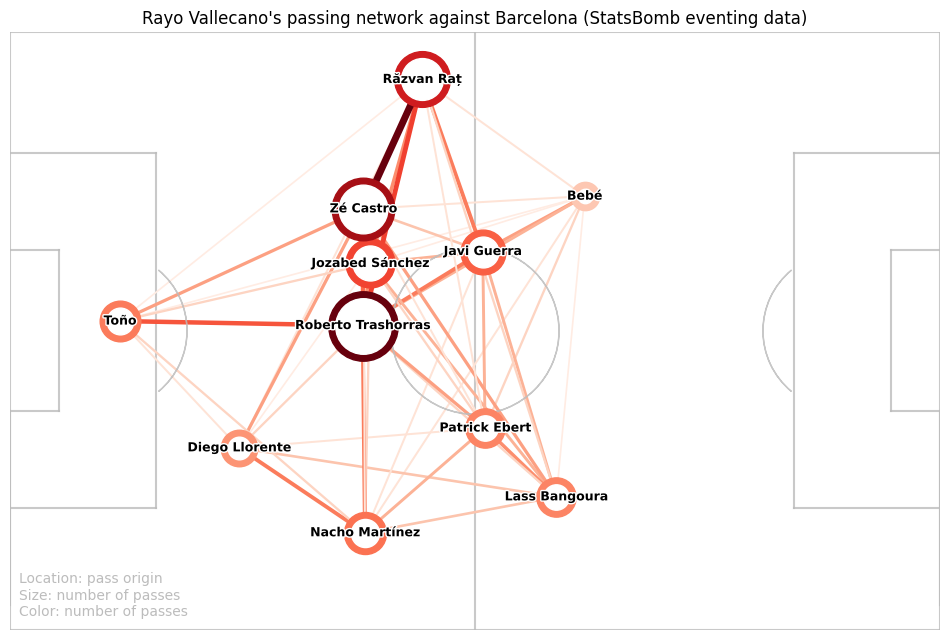

                    num_passes
player_name                   
Bebé                         8
Diego Llorente              14
Javi Guerra                 20
Jozabed Sánchez             23
Lass Bangoura               16
Nacho Martínez              18
Patrick Ebert               16
Roberto Trashorras          38
Răzvan Raț                  28
Toño                        17
Zé Castro                   33
38
2310
187
Centralisation index is  0.08095238095238096


In [14]:
passing_network_FoT(dfSpain, 3825627, 'Rayo Vallecano')

## Defensive

In [15]:
def dfGeneralStatsDefense(df):

    recoveries = df[(df['type']=='Ball Recovery') & (df.ball_recovery_recovery_failure != True)].copy()
    recoveries[['x', 'y']] = recoveries['location'].apply(pd.Series)

    recoveries_opponent_field = recoveries.loc[recoveries.x >= 60].copy()
    recoveries_f3 = recoveries.loc[recoveries.x >= 80].copy()

    duels = df[(df['type']=='Duel')].copy()
    duels_won =  df[(df.duel_outcome == 'Won') | (df.duel_outcome == 'Success In Play') | (df.duel_outcome == 'Success Out')]

    fouls = df[(df['type']=='Foul Committed')].copy()
    fouls[['x', 'y']] = fouls['location'].apply(pd.Series)
    fouls_opponent_field = fouls.loc[fouls.x >= 60].copy()
    fouls_f3 = fouls.loc[fouls.x >= 80].copy()

    matches_per_team = df.drop_duplicates(subset=['match_id', 'team'])[['match_id', 'team']]

    def count_opponent_shots(row):
        match_id = row['match_id']
        team = row['team']
        opponent_shots = df[(df['match_id'] == match_id) & (df['type'] == 'Shot') & (df['team'] != team)]

        match_row = df[df['match_id'] == match_id].iloc[0]
        
        if match_row['home_team'] == team:
            clean_sheet = 1 if match_row['away_score'] == 0 else 0
        else:
            clean_sheet = 1 if match_row['home_score'] == 0 else 0
        
        num_shots = len(opponent_shots)
        total_xG = opponent_shots['shot_statsbomb_xg'].sum()
        total_goals = len(opponent_shots.loc[opponent_shots.shot_outcome == 'Goal'])
        shots_onTarget = len(opponent_shots[(opponent_shots['shot_outcome']=='Saved')|(opponent_shots['shot_outcome']=='Saved to Post')|(opponent_shots['shot_outcome']=='Goal')])
        return num_shots, shots_onTarget, total_xG, total_goals, clean_sheet

    matches_per_team['shots_received'], matches_per_team['shots_onTarget'], matches_per_team['xGA'], matches_per_team['goals_against'], matches_per_team['clean_sheet'] = zip(*matches_per_team.apply(count_opponent_shots, axis=1))

    combined_df = recoveries.groupby(['team'])['team'].count().to_frame()
    combined_df = combined_df.rename(columns={'team': 'recoveries'})
    combined_df['recoveries_opponent_field'] = recoveries_opponent_field.groupby(['team'])['team'].count().to_frame()
    combined_df['recoveries_f3'] = recoveries_f3.groupby(['team'])['team'].count().to_frame()
    combined_df['duels'] = duels.groupby(['team'])['team'].count().to_frame()
    combined_df['duels_won'] = duels_won.groupby(['team'])['team'].count().to_frame()
    combined_df['fouls_committed'] = fouls.groupby(['team'])['team'].count().to_frame()
    combined_df['fouls_opponent_field'] = fouls_opponent_field.groupby(['team'])['team'].count().to_frame()
    combined_df['fouls_f3'] = fouls_f3.groupby(['team'])['team'].count().to_frame()
    combined_df['shots_against'] = matches_per_team.groupby(['team'])['shots_received'].sum().to_frame()
    combined_df['shots_onTarget'] = matches_per_team.groupby(['team'])['shots_onTarget'].sum().to_frame()
    combined_df['xGA'] = matches_per_team.groupby(['team'])['xGA'].sum().to_frame()
    combined_df['goals_against'] = matches_per_team.groupby(['team'])['goals_against'].sum().to_frame()
    combined_df['clean_sheets'] = matches_per_team.groupby(['team'])['clean_sheet'].sum().to_frame()
    combined_df['MP'] = df.match_week.max()
    combined_df = combined_df.reset_index()


    return combined_df


In [16]:
dfDefenseSpain = dfGeneralStatsDefense(dfSpain)
dfDefenseItaly = dfGeneralStatsDefense(dfItaly)
dfDefenseEngland = dfGeneralStatsDefense(dfEngland)
dfDefenseGermany = dfGeneralStatsDefense(dfGermany)

In [17]:
pd.options.display.max_rows = 80
dfMergedDefense = pd.concat([dfDefenseItaly, dfDefenseEngland, dfDefenseGermany, dfDefenseSpain], axis=0)
dfMergedDefense = dfMergedDefense.sort_values('goals_against', ascending=False).reset_index(drop=True)
dfMergedDefense

team  recoveries  recoveries_opponent_field  \
0                  Frosinone        1858                        746   
1                   Espanyol        1685                        637   
2                Aston Villa        1842                        675   
3             Rayo Vallecano        1820                        729   
4              VfB Stuttgart        1643                        686   
5            AFC Bournemouth        1864                        735   
6                 Levante UD        1794                        706   
7                    Granada        1710                        661   
8                     Getafe        1832                        725   
9               Norwich City        1830                        757   
10          Newcastle United        1833                        651   
11                   Palermo        2045                        775   
12             Werder Bremen        1754                        732   
13            Sporting Gijón        1768                        653   
14             Hellas Verona        1924                        763   
15               Hannover 96        1611                        603   
16                Sunderland        1793                        676   
17    RC Deportivo La Coruña        1770                        712   
18                     Eibar        1934                        843   
19                   Udinese        1817                        709   
20                 Sampdoria        1810                        679   
21                     Carpi        2035                        752   
22                Celta Vigo        1895                        724   
23                Stoke City        1917                        689   
24                   Everton        2001                        738   
25                Las Palmas        1819                        608   
26                    Torino        1754                        599   
27       Eintracht Frankfurt        1679                        644   
28                   Chelsea        1852                        785   
29                Real Betis        1832                        710   
30                  Augsburg        1501                        538   
31                Hoffenheim        1546                        567   
32              Darmstadt 98        1489                        632   
33                     Lazio        2127                        875   
34                 Liverpool        1999                        872   
35           West Ham United        1941                        777   
36                 Wolfsburg        1675                        585   
37                   Sevilla        1671                        664   
38                    Empoli        1882                        748   
39                   Watford        1885                        756   
40            Crystal Palace        1971                        859   
41                  Valencia        1745                        647   
42  Borussia Mönchengladbach        1647                        635   
43              Swansea City        1672                        648   
44                Schalke 04        1614                        623   
45             Real Sociedad        1788                        782   
46                  Atalanta        1801                        688   
47      West Bromwich Albion        1852                        716   
48                     Genoa        2042                        779   
49                   Bologna        1907                        741   
50              Hamburger SV        1690                        644   
51                    Chievo        1866                        726   
52             Athletic Club        1910                        881   
53                  AC Milan        1993                        827   
54             Hertha Berlin        1479                        566   
55                Ingolstadt        1633        

In [18]:
dfDefenseSpain.to_csv('dataFrames/dfDefenseSpain.csv', index=False)
dfDefenseGermany.to_csv('dataFrames/dfDefenseGermany.csv', index=False)
dfDefenseItaly.to_csv('dataFrames/dfDefenseItaly.csv', index=False)
dfDefenseEngland.to_csv('dataFrames/dfDefenseEngland.csv', index=False)
dfMergedDefense.to_csv('dataFrames/dfMergedDefense.csv', index=False)

#### PPDA

Defensive actions: 
    - Duel.
    - Interceptions.
    - Fouls

In [19]:
import pandas as pd

# Suponiendo que ya tienes un DataFrame llamado df

# Paso 1: Obtener la lista de partidos para cada equipo
def PPDA(df):
    matches_per_team = df.drop_duplicates(subset=['match_id', 'team'])[['match_id', 'team', 'match_week']]
    passes = df.loc[df['type']=='Pass']
    passes[['x', 'y']] = passes['location'].apply(pd.Series)

    defensive = df.loc[(df['duel_type']=='Tackle') | (df['type']=='Interception') | (df['type']=='Foul Committed') | ((df['type']=='Block'))
                       | (df['type']=='50-50')]
    defensive[['x', 'y']] = defensive['location'].apply(pd.Series)

    # Función para contar tiros del equipo rival en un partido
    def calculate_ppda(row):
        match_id = row['match_id']
        team = row['team']
        opponent_passes = passes[(passes['match_id'] == match_id) & (passes['team'] != team) & (passes['x'] < 50)]
        defensive_actions = defensive[(defensive['match_id'] == match_id) & (defensive['team'] == team) & (defensive['x'] > 70)]
        if (len(defensive_actions) == 0):
            ppda = 0
        else:
            ppda = len(opponent_passes)/len(defensive_actions)
        return ppda

    # Aplicar la función a cada fila
    matches_per_team['ppda'] = matches_per_team.apply(calculate_ppda, axis=1)

    # Agrupar por equipo y sumar los tiros recibidos
    matches_per_team = matches_per_team.groupby(['team', 'match_week'])['ppda'].sum().reset_index()

    return matches_per_team

In [20]:
dfPPDASpain = PPDA(dfSpain)
dfPPDAGermany = PPDA(dfGermany)
dfPPDAItaly = PPDA(dfItaly)
dfPPDAEngland = PPDA(dfEngland)
dfMergedPPDA = pd.concat([dfPPDAItaly, dfPPDAEngland, dfPPDAGermany, dfPPDASpain], axis=0)

dfPPDASpain.to_csv('dataFrames/dfPPDASpain.csv', index=False)
dfPPDAGermany.to_csv('dataFrames/dfPPDAGermany.csv', index=False)
dfPPDAItaly.to_csv('dataFrames/dfPPDAItaly.csv', index=False)
dfPPDAEngland.to_csv('dataFrames/dfPPDAEngland.csv', index=False)
dfMergedPPDA.to_csv('dataFrames/dfPPDADefense.csv', index=False)

In [32]:
PPDA = dfMergedPPDA.groupby('team')['ppda'].mean().reset_index().sort_values('ppda', ascending=True)
dfMergedDefense = dfMergedDefense.merge(PPDA, on='team', how='left')
dfMergedDefense

team  recoveries  recoveries_opponent_field  \
0                  Frosinone        1858                        746   
1                   Espanyol        1685                        637   
2                Aston Villa        1842                        675   
3             Rayo Vallecano        1820                        729   
4              VfB Stuttgart        1643                        686   
5            AFC Bournemouth        1864                        735   
6                 Levante UD        1794                        706   
7                    Granada        1710                        661   
8                     Getafe        1832                        725   
9               Norwich City        1830                        757   
10          Newcastle United        1833                        651   
11                   Palermo        2045                        775   
12             Werder Bremen        1754                        732   
13            Sporting Gijón        1768                        653   
14             Hellas Verona        1924                        763   
15               Hannover 96        1611                        603   
16                Sunderland        1793                        676   
17    RC Deportivo La Coruña        1770                        712   
18                     Eibar        1934                        843   
19                   Udinese        1817                        709   
20                 Sampdoria        1810                        679   
21                     Carpi        2035                        752   
22                Celta Vigo        1895                        724   
23                Stoke City        1917                        689   
24                   Everton        2001                        738   
25                Las Palmas        1819                        608   
26                    Torino        1754                        599   
27       Eintracht Frankfurt        1679                        644   
28                   Chelsea        1852                        785   
29                Real Betis        1832                        710   
30                  Augsburg        1501                        538   
31                Hoffenheim        1546                        567   
32              Darmstadt 98        1489                        632   
33                     Lazio        2127                        875   
34                 Liverpool        1999                        872   
35           West Ham United        1941                        777   
36                 Wolfsburg        1675                        585   
37                   Sevilla        1671                        664   
38                    Empoli        1882                        748   
39                   Watford        1885                        756   
40            Crystal Palace        1971                        859   
41                  Valencia        1745                        647   
42  Borussia Mönchengladbach        1647                        635   
43              Swansea City        1672                        648   
44                Schalke 04        1614                        623   
45             Real Sociedad        1788                        782   
46                  Atalanta        1801                        688   
47      West Bromwich Albion        1852                        716   
48                     Genoa        2042                        779   
49                   Bologna        1907                        741   
50              Hamburger SV        1690                        644   
51                    Chievo        1866                        726   
52             Athletic Club        1910                        881   
53                  AC Milan        1993                        827   
54             Hertha Berlin        1479                        566   
55                Ingolstadt        1633        

In [33]:
#dfMergedDefense = dfMergedDefense.merge(PPDA, on='team', how='left')
dfMergedDefense.to_csv('dataFrames/dfMergedDefense.csv', index=False)

In [23]:
dfMergedDefense = pd.read_csv('dataFrames/dfMergedDefense.csv')
dfMergedShot = pd.read_csv('dataFrames/dfMergedShot.csv')
dfMergedPass = pd.read_csv('dataFrames/dfMergedPass.csv')

 ## K-Means

In [28]:
dfMergedDefense = pd.read_csv('dataFrames/dfMergedDefense.csv')
dfMergedShot = pd.read_csv('dataFrames/dfMergedShot.csv')
dfMergedPass = pd.read_csv('dataFrames/dfMergedPass.csv')

In [34]:
dfMergedDefense

team  recoveries  recoveries_opponent_field  \
0                  Frosinone        1858                        746   
1                   Espanyol        1685                        637   
2                Aston Villa        1842                        675   
3             Rayo Vallecano        1820                        729   
4              VfB Stuttgart        1643                        686   
5            AFC Bournemouth        1864                        735   
6                 Levante UD        1794                        706   
7                    Granada        1710                        661   
8                     Getafe        1832                        725   
9               Norwich City        1830                        757   
10          Newcastle United        1833                        651   
11                   Palermo        2045                        775   
12             Werder Bremen        1754                        732   
13            Sporting Gijón        1768                        653   
14             Hellas Verona        1924                        763   
15               Hannover 96        1611                        603   
16                Sunderland        1793                        676   
17    RC Deportivo La Coruña        1770                        712   
18                     Eibar        1934                        843   
19                   Udinese        1817                        709   
20                 Sampdoria        1810                        679   
21                     Carpi        2035                        752   
22                Celta Vigo        1895                        724   
23                Stoke City        1917                        689   
24                   Everton        2001                        738   
25                Las Palmas        1819                        608   
26                    Torino        1754                        599   
27       Eintracht Frankfurt        1679                        644   
28                   Chelsea        1852                        785   
29                Real Betis        1832                        710   
30                  Augsburg        1501                        538   
31                Hoffenheim        1546                        567   
32              Darmstadt 98        1489                        632   
33                     Lazio        2127                        875   
34                 Liverpool        1999                        872   
35           West Ham United        1941                        777   
36                 Wolfsburg        1675                        585   
37                   Sevilla        1671                        664   
38                    Empoli        1882                        748   
39                   Watford        1885                        756   
40            Crystal Palace        1971                        859   
41                  Valencia        1745                        647   
42  Borussia Mönchengladbach        1647                        635   
43              Swansea City        1672                        648   
44                Schalke 04        1614                        623   
45             Real Sociedad        1788                        782   
46                  Atalanta        1801                        688   
47      West Bromwich Albion        1852                        716   
48                     Genoa        2042                        779   
49                   Bologna        1907                        741   
50              Hamburger SV        1690                        644   
51                    Chievo        1866                        726   
52             Athletic Club        1910                        881   
53                  AC Milan        1993                        827   
54             Hertha Berlin        1479                        566   
55                Ingolstadt        1633        

In [35]:
dfShotsModel = dfMergedShot[['team', 'total_shots', 'onTarget', 'goals', 'xG_total', 'Shot_to_goal_ratio', 'Shot_onTarget_to_goal_ratio','xG/shot']]
dfDefensiveModel = dfMergedDefense[['team', 'recoveries', 'recoveries_f3', 'duels_won', 'fouls_committed', 'shots_against', 'shots_onTarget', 'xGA', 'goals_against', 'clean_sheets', 'ppda']]
dfPassModel = dfMergedPass[['team', 'total_passes', 'f3_passes', 'short_passes', 'long_passes', 'average_pass_length', 'crosses']]

dfModel = pd.merge(pd.merge(dfShotsModel, dfDefensiveModel, on='team', how='outer'), dfPassModel, on='team', how='outer')

dfModel.rename(columns={'shots_onTarget': 'shots_onTarget_against'}, inplace=True)



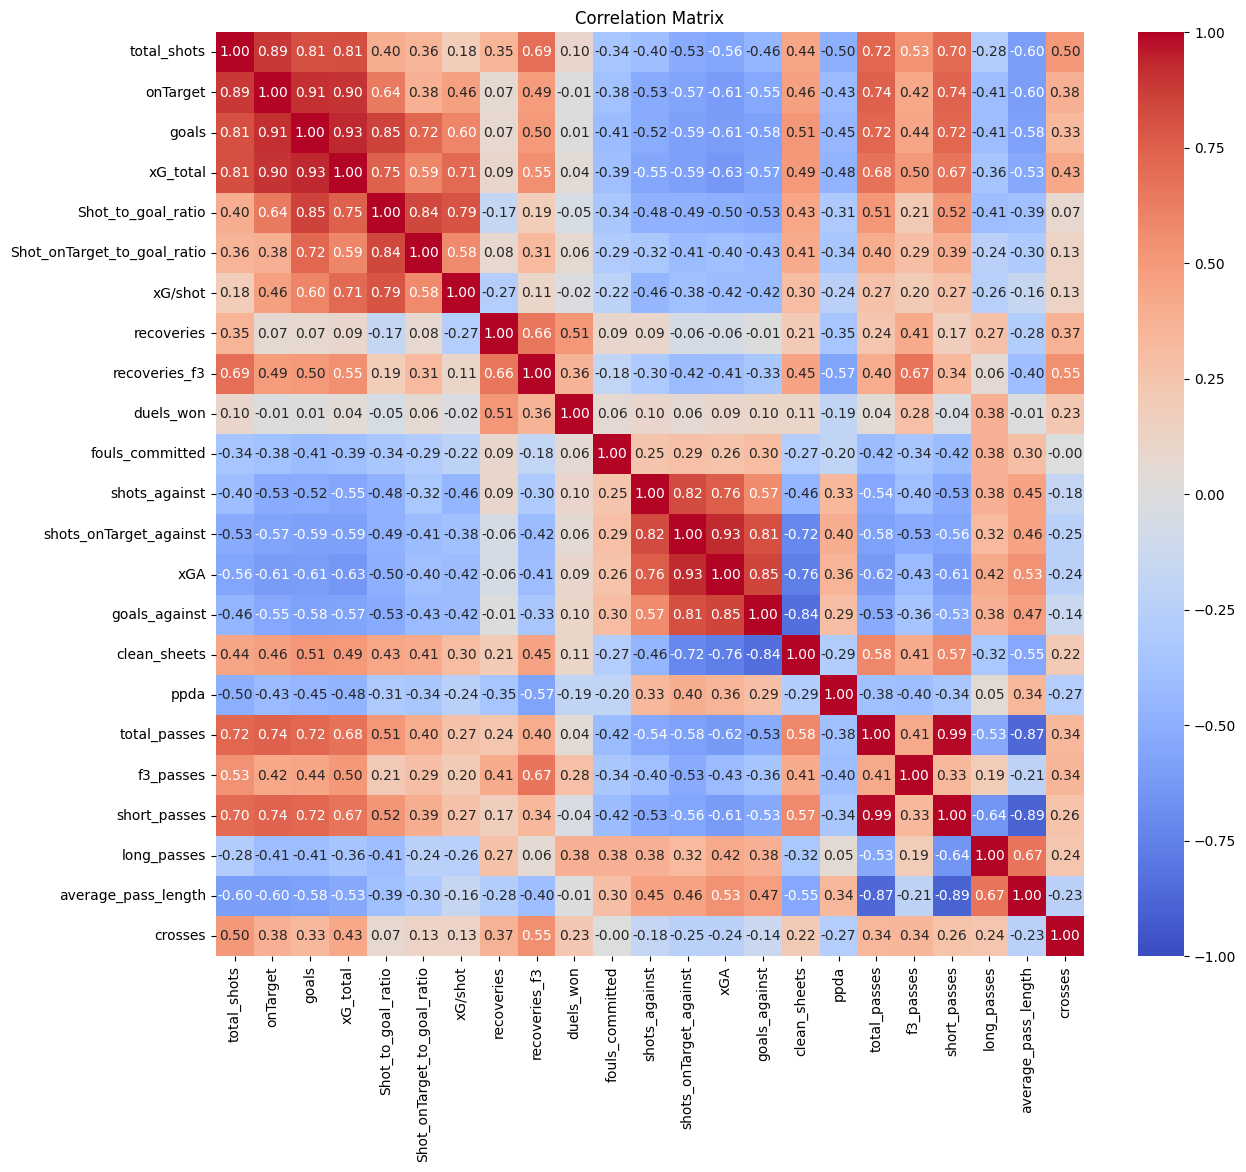

In [36]:
correlation_matrix = dfModel.drop('team', axis=1).corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

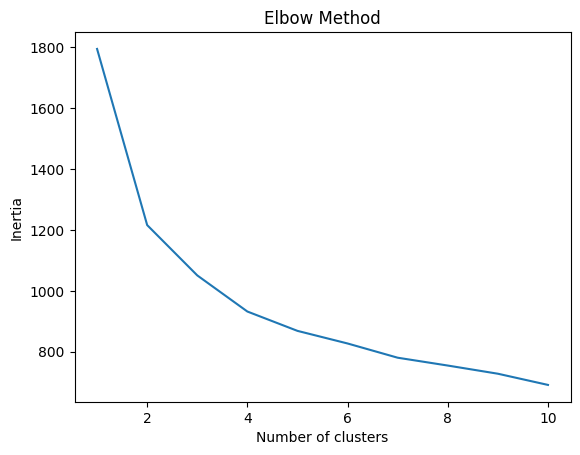

In [37]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dfModel.drop('team', axis=1)) 

inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [38]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters = 4, random_state=80)
kmeans.fit(df_scaled)
dfModel['cluster'] = kmeans.predict(df_scaled)

In [39]:
dfModel.cluster.value_counts()

0    27
3    20
2    19
1    12
Name: cluster, dtype: int64

In [40]:
clusters = dfModel.groupby('cluster')['team'].apply(list)

# Now, clusters is a Series where the index is the cluster label and the value is a list of teams in that cluster
for cluster_label, teams in clusters.items():
    print(f'cluster {cluster_label}: {", ".join(teams)}')

cluster 0: Rayo Vallecano, Frosinone, Crystal Palace, Atalanta, Hellas Verona, RC Deportivo La Coruña, Udinese, Sunderland, Watford, Levante UD, Sampdoria, Getafe, Carpi, Granada, Chievo, Ingolstadt, Stoke City, Eibar, Norwich City, Palermo, Real Betis, Newcastle United, Espanyol, West Bromwich Albion, Bologna, Aston Villa, Sporting Gijón
cluster 1: Real Madrid, Napoli, Tottenham Hotspur, Bayern Munich, Manchester City, Juventus, Barcelona, AS Roma, Arsenal, Fiorentina, Borussia Dortmund, Atlético Madrid
cluster 2: Wolfsburg, VfB Stuttgart, Schalke 04, Torino, Borussia Mönchengladbach, Werder Bremen, Swansea City, Augsburg, Las Palmas, Valencia, FC Köln, Hoffenheim, FSV Mainz 05, Hannover 96, Hamburger SV, Eintracht Frankfurt, Darmstadt 98, Villarreal, Hertha Berlin
cluster 3: Liverpool, AC Milan, West Ham United, Chelsea, Inter Milan, Southampton, Leicester City, Lazio, Everton, Sassuolo, Empoli, Bayer Leverkusen, AFC Bournemouth, Genoa, Sevilla, Real Sociedad, Athletic Club, Málaga, 

In [41]:
cluster_summary = dfModel.groupby('cluster').mean()
cluster_summary_attack = cluster_summary[['total_shots', 'onTarget', 'goals', 'xG_total', 'Shot_to_goal_ratio', 'Shot_onTarget_to_goal_ratio']]
cluster_summary_build = cluster_summary[['total_passes', 'f3_passes', 'short_passes', 'long_passes', 'crosses']]
cluster_summary_defense = cluster_summary[['recoveries', 'recoveries_f3', 'duels_won', 'fouls_committed', 'shots_against', 'shots_onTarget_against', 'xGA', 'goals_against']]
cluster_summary

total_shots    onTarget      goals   xG_total  Shot_to_goal_ratio  \
cluster                                                                      
0         434.259259  137.000000  38.074074  40.375034            8.782086   
1         604.083333  224.500000  77.416667  67.485983           12.824329   
2         415.052632  147.526316  42.736842  42.216909           10.331592   
3         502.250000  165.200000  51.050000  50.030581           10.167231   

         Shot_onTarget_to_goal_ratio   xG/shot   recoveries  recoveries_f3  \
cluster                                                                      
0                          27.863776  0.093179  1843.111111     396.703704   
1                          34.496043  0.112227  1827.666667     467.750000   
2                          29.088335  0.101875  1640.368421     337.578947   
3                          30.895574  0.099761  1916.150000     440.150000   

          duels_won  fouls_committed  shots_against  shots_onTarget_against  \
cluster                                                                       
0        447.481481       604.370370     523.407407              178.407407   
1        422.833333       501.666667     368.166667              117.500000   
2        387.578947       569.684211     475.210526              169.000000   
3        451.900000       549.500000     466.300000              153.100000   

               xGA  goals_against  clean_sheets       ppda  total_passes  \
cluster                                                                    
0        54.833924      58.555556      8.111111  14.208645  16190.666667   
1        32.618812      30.250000     16.250000  11.921833  23073.583333   
2        49.536519      49.421053      8.263158  15.058582  16365.421053   
3        44.477752      45.350000     11.900000  12.623370  18909.950000   

           f3_passes  short_passes  long_passes  average_pass_length  \
cluster                                                                
0        2195.777778   8139.629630  2763.037037            20.971340   
1        2393.000000  15054.833333  2249.166667            18.351978   
2        1944.631579   8878.842105  2363.894737            20.722504   
3        2253.500000  10743.100000  2531.550000            19.683314   

            crosses  
cluster              
0        457.296296  
1        506.000000  
2        382.105263  
3        503.500000

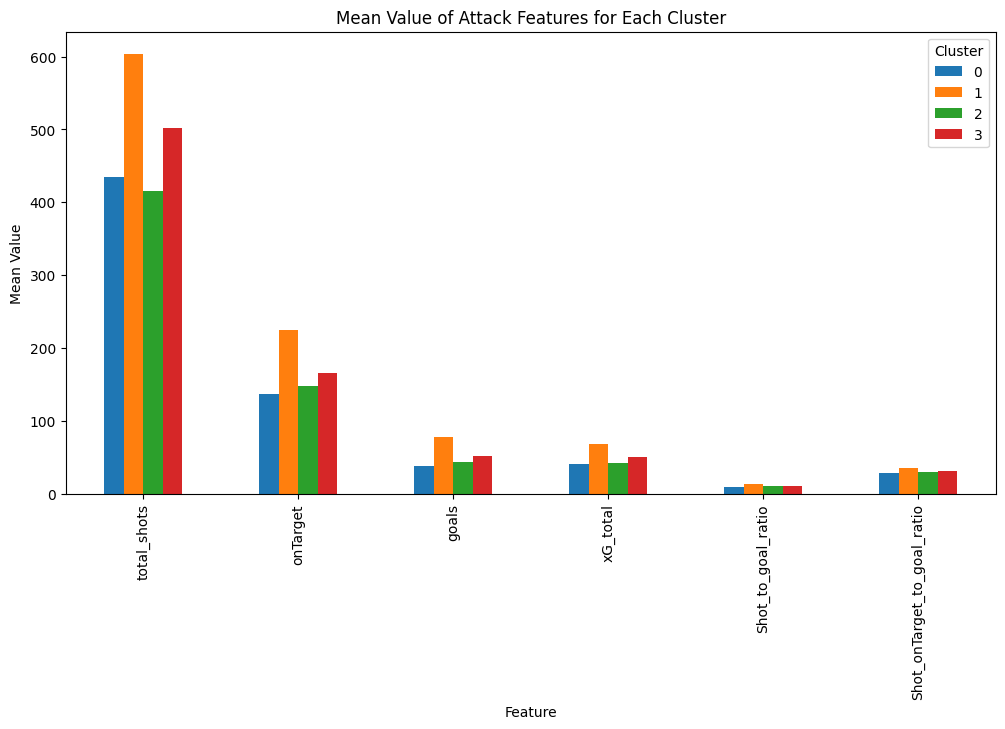

In [42]:
cluster_means_T = cluster_summary_attack.transpose()
cluster_means_T.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Value of Attack Features for Each Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Feature')
plt.xticks(rotation=90)  # Rotate x-labels for better readability
plt.legend(title='Cluster')

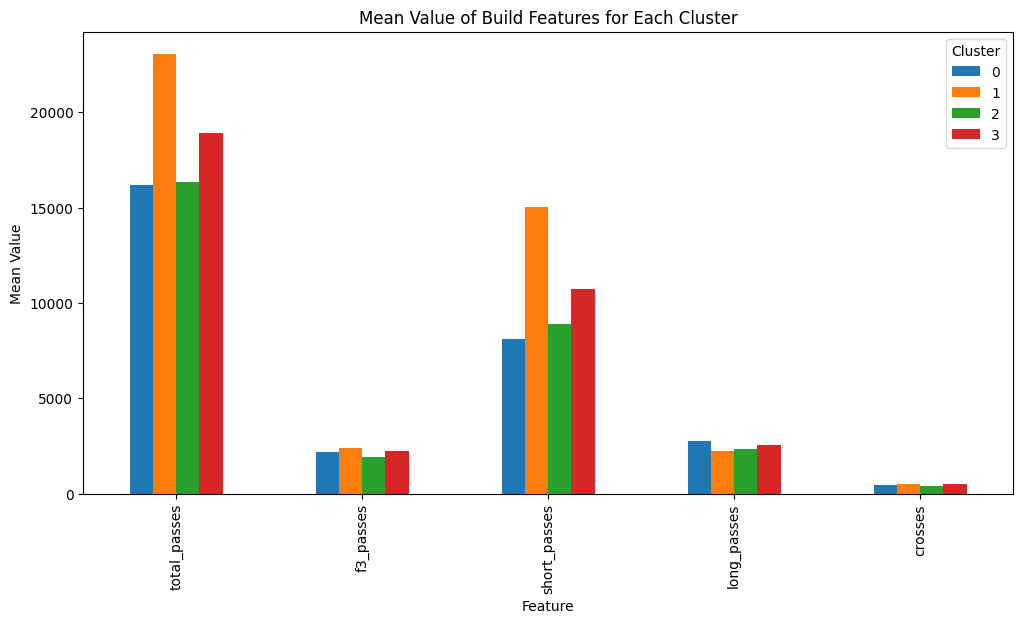

In [43]:
cluster_means_T = cluster_summary_build.transpose()
cluster_means_T.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Value of Build Features for Each Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Feature')
plt.xticks(rotation=90)  # Rotate x-labels for better readability
plt.legend(title='Cluster')

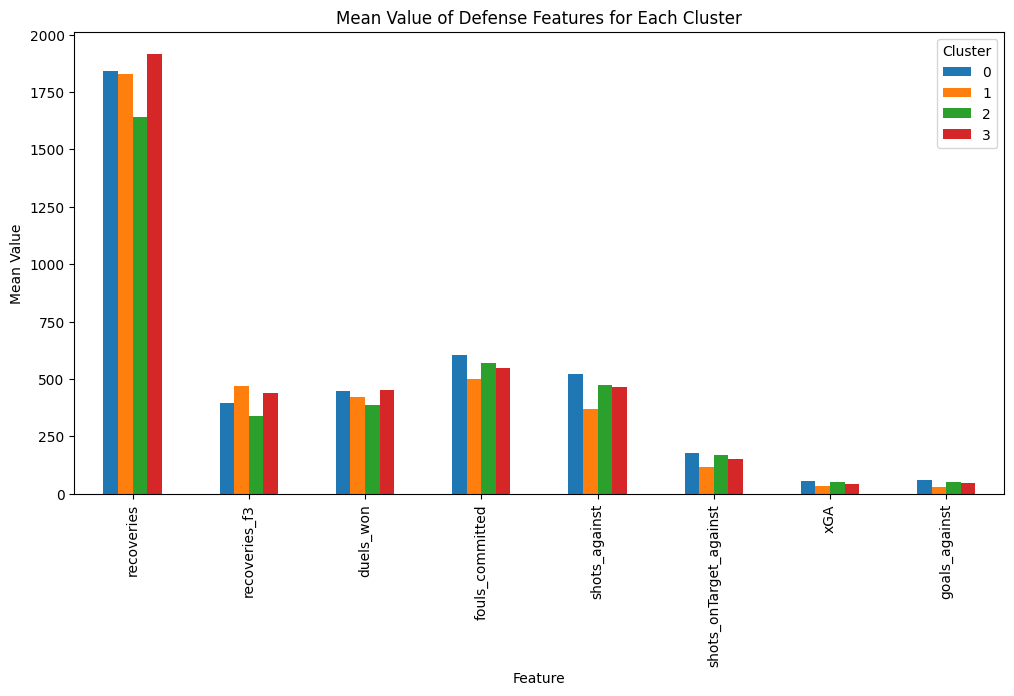

In [44]:
cluster_means_T = cluster_summary_defense.transpose()
cluster_means_T.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Value of Defense Features for Each Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Feature')
plt.xticks(rotation=90)  # Rotate x-labels for better readability
plt.legend(title='Cluster')

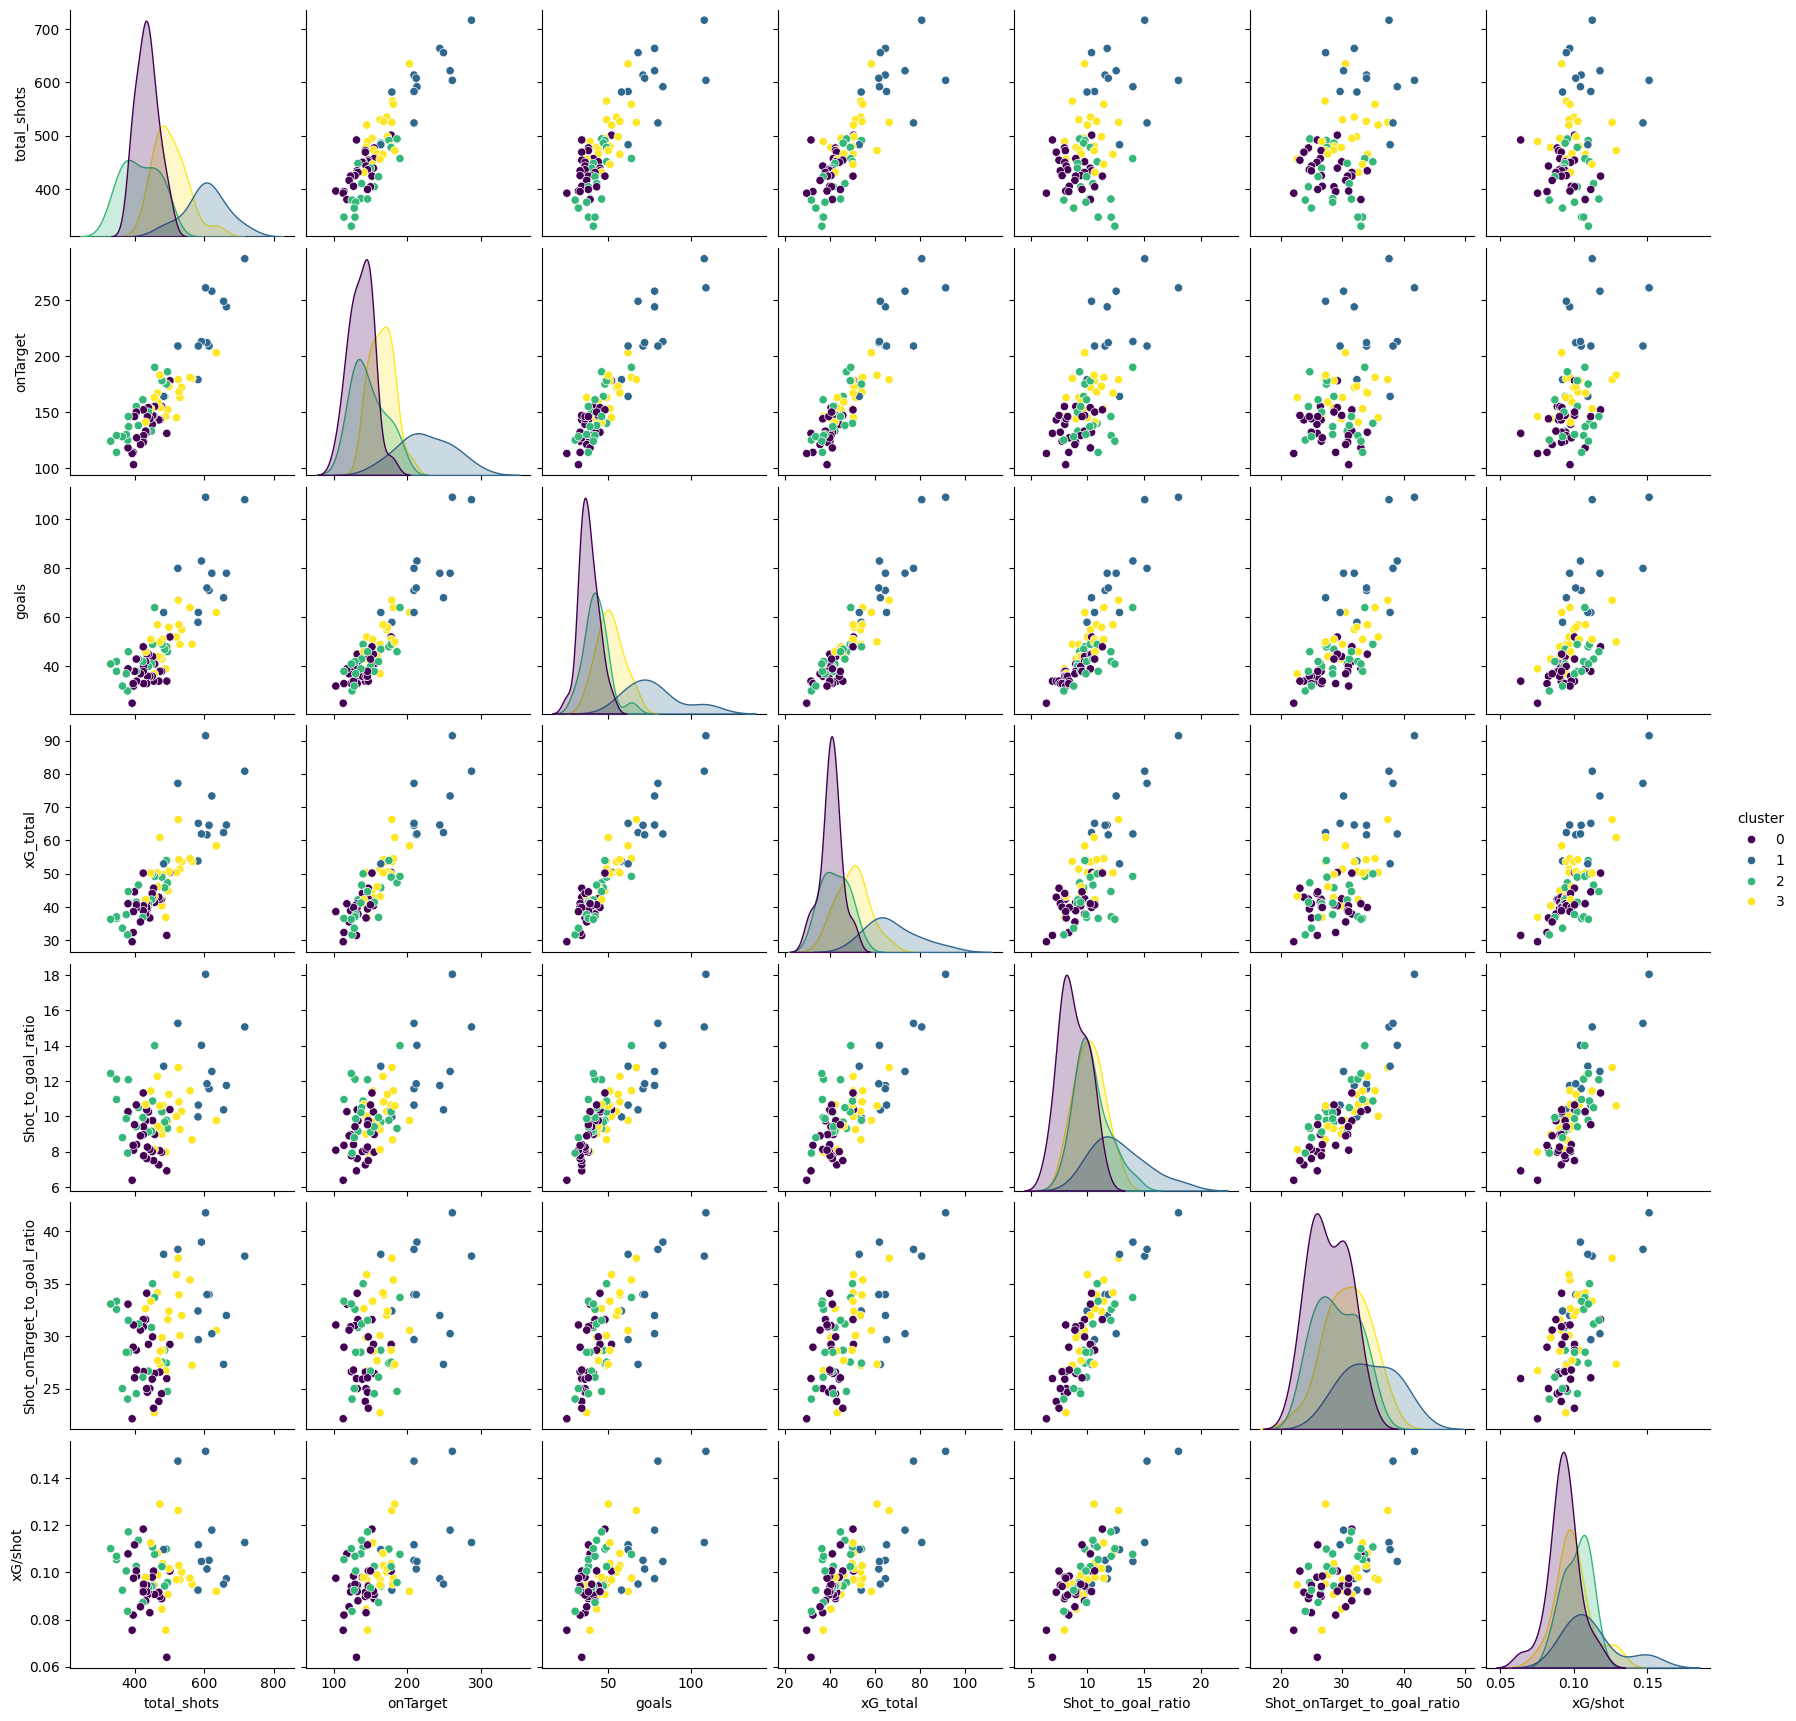

In [45]:
selected_features_attack = ['total_shots', 'onTarget', 'goals', 'xG_total', 'Shot_to_goal_ratio', 'Shot_onTarget_to_goal_ratio', 'xG/shot', 'cluster']
sns.pairplot(dfModel[selected_features_attack], hue='cluster', palette='viridis')


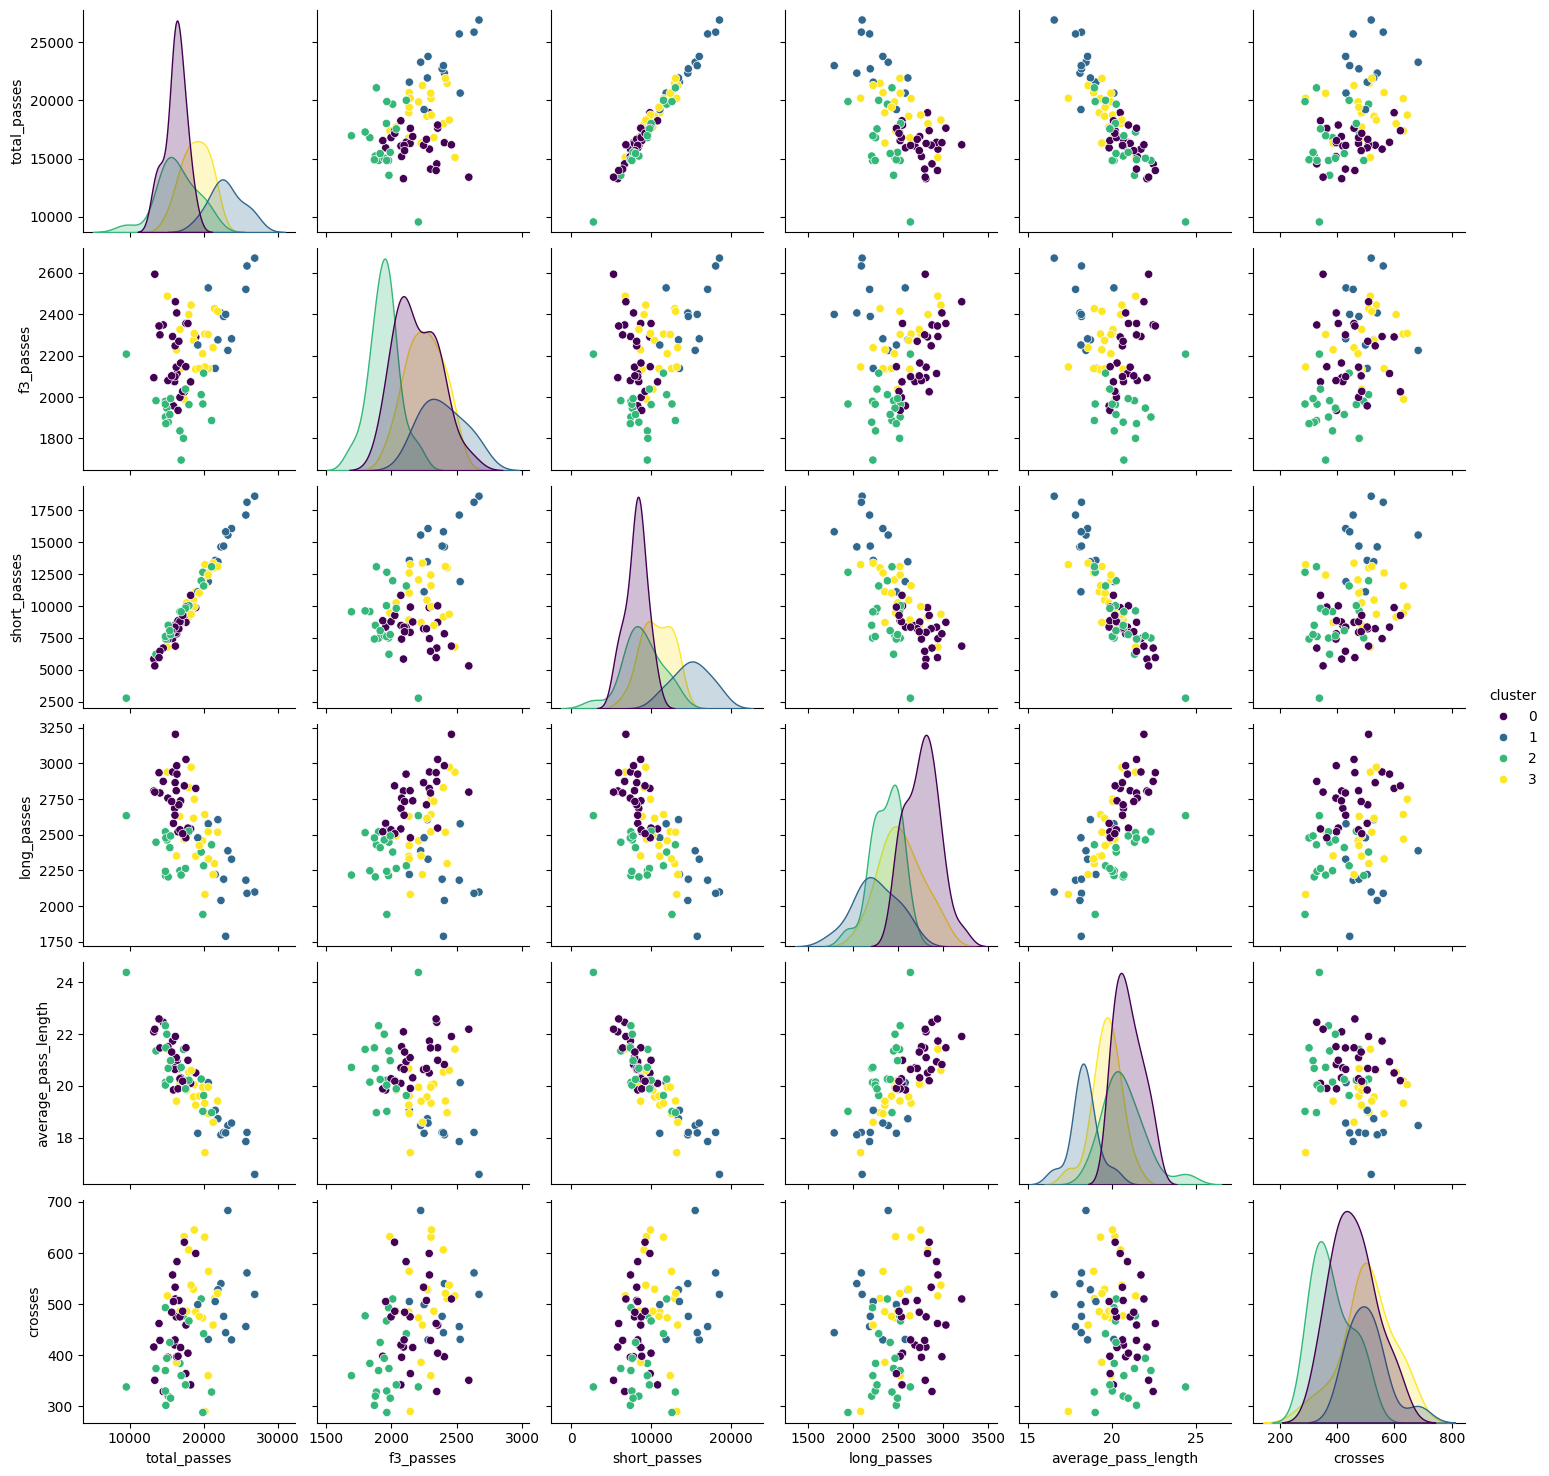

In [46]:
selected_features_build = ['total_passes', 'f3_passes', 'short_passes', 'long_passes', 'average_pass_length', 'crosses', 'cluster']
sns.pairplot(dfModel[selected_features_build], hue='cluster', palette='viridis')

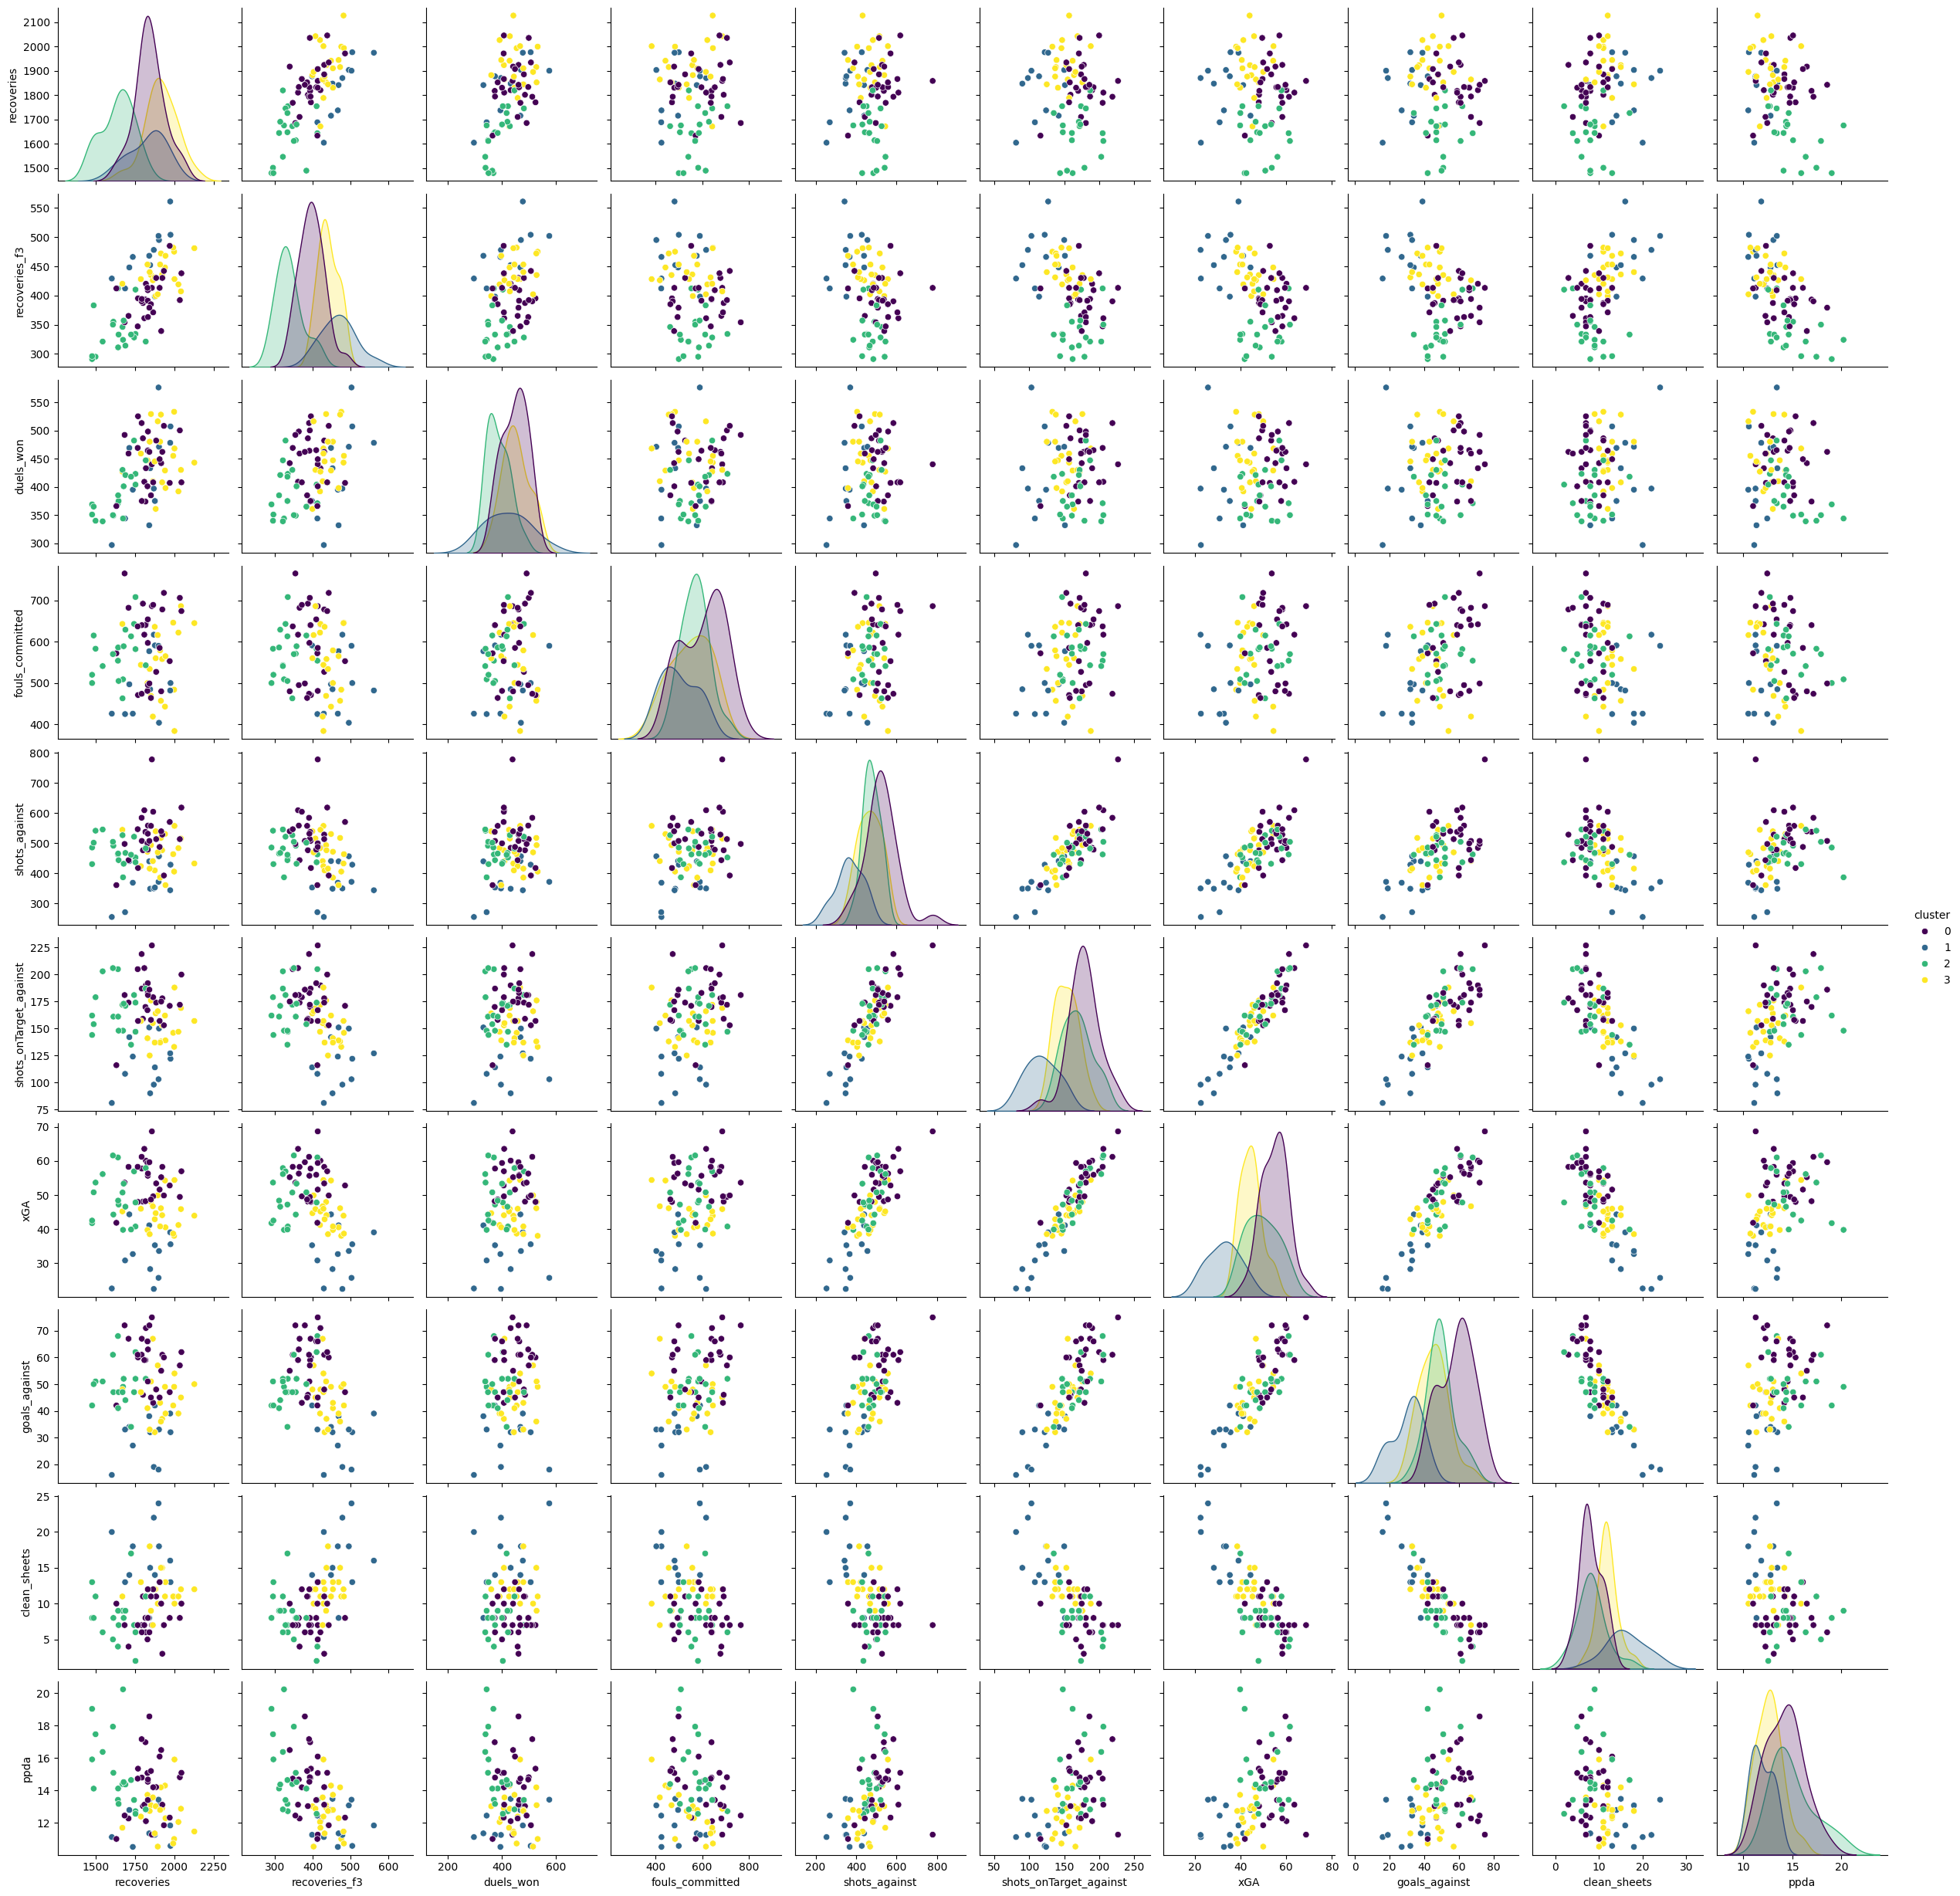

In [47]:
selected_features_defense = ['recoveries', 'recoveries_f3', 'duels_won', 'fouls_committed', 'shots_against', 'shots_onTarget_against', 'xGA', 'goals_against', 'clean_sheets', 'ppda', 'cluster']
sns.pairplot(dfModel[selected_features_defense], hue='cluster', palette='viridis')

In [48]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time

def get_stats(url, id_table):
    # Set up Chrome options
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')

    # Specify the path to chromedriver.exe using Service
    service = Service(ChromeDriverManager().install())

    # Initialize the Chrome driver with the service and options
    driver = webdriver.Chrome(service=service, options=options)

    # Load the webpage
    driver.get(url)

    # Wait for the JavaScript to render
    time.sleep(5)

    # Get the page source
    page_source = driver.page_source

    # Close the WebDriver
    driver.quit()

    # Parse the page source with BeautifulSoup
    soup = BeautifulSoup(page_source, 'html.parser')

    # Find the table
    table = soup.find('table', {'id': id_table})

    if table:
        print(table)

        # Convert the table to a DataFrame
        df = pd.read_html(str(table))[0]
        # This line might need adjustment depending on the table's header structure
        df.columns = [col[1] if isinstance(col, tuple) else col for col in df.columns.values]
        df = df.reset_index(drop=True)
        return df
    else:
        print(f'Table with id="stats_standard" not found for URL: {url}')
        return None

# URLs for the Premier League and La Liga stats
url_premier = 'https://fbref.com/en/comps/9/2015-2016/2015-2016-Premier-League-Stats'
id_premier = 'results2015-201691_overall'
url_laliga = 'https://fbref.com/en/comps/12/2015-2016/2015-2016-La-Liga-Stats'
id_laliga = 'results2015-2016121_overall'
url_bundesliga = 'https://fbref.com/en/comps/20/2015-2016/2015-2016-Bundesliga-Stats'
id_bundesliga = 'results2015-2016201_overall'
url_serieA = 'https://fbref.com/en/comps/11/2015-2016/2015-2016-Serie-A-Stats'
id_serieA = 'results2015-2016111_overall'


# Get the stats for each league
df_premier = get_stats(url_premier, id_premier)
df_laliga = get_stats(url_laliga, id_laliga)
df_bundesliga = get_stats(url_bundesliga, id_bundesliga)
df_serieA = get_stats(url_serieA, id_serieA)

<table class="stats_table sortable min_width force_mobilize now_sortable sticky_table eq2 re2 le2" data-cols-to-freeze=",2" id="results2015-201691_overall"> <caption>Regular season Table</caption> <colgroup><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/><col/></colgroup> <thead> <tr> <th aria-label="Rank" class="poptip sort_default_asc center" data-stat="rank" data-tip="&lt;strong&gt;Rank&lt;/strong&gt;&lt;br&gt;Squad finish in competition&lt;br&gt;Finish within the league or competition.&lt;br&gt;For knockout competitions may show final round reached.&lt;br&gt;Colors and arrows represent promotion/relegation or qualifiation for continental cups.&lt;br&gt;Trophy indicates team won league whether by playoffs or by leading the table.&lt;br&gt;Star indicates topped table in league USING another means of naming champion." scope="col">Rk</th> <th aria-label="Squad" class="poptip sort_default_asc center" data-stat="team" scope="col">Squad</th> <th aria-la

In [49]:
df_classification = pd.concat([df_premier, df_laliga, df_bundesliga, df_serieA], axis=0)
team_name_mapping = {
    "Tottenham": "Tottenham Hotspur",
    "Roma": "AS Roma",
    "Milan": "AC Milan",
    "West Ham": "West Ham United",
    "Inter": "Inter Milan",
    "Dortmund": "Borussia Dortmund",
    "Stuttgart": "VfB Stuttgart",
    "Leverkusen": "Bayer Leverkusen",
    "Bournemouth": "AFC Bournemouth",
    "La Coruña": "RC Deportivo La Coruña",
    "M'Gladbach": "Borussia Mönchengladbach",
    "Levante": "Levante UD",
    "Manchester Utd": "Manchester United",
    "Ingolstadt 04": "Ingolstadt",
    "Betis": "Real Betis",
    "Köln": "FC Köln",
    "Newcastle Utd": "Newcastle United",
    "West Brom": "West Bromwich Albion",
    "Mainz 05": "FSV Mainz 05",
    "Eint Frankfurt": "Eintracht Frankfurt",
    "Hertha BSC": "Hertha Berlin"
}
df_classification['Squad'] = df_classification['Squad'].replace(team_name_mapping)
df_merged = pd.DataFrame()
df_merged = pd.merge(dfModel, df_classification, left_on='team', right_on='Squad', how='left')
df_merged = df_merged.drop(['Squad', 'MP', 'GF', 'GA', 'GD', 'Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes'], axis=1)
df_merged.to_csv('dataFrames/dfModel.csv', index=False)


In [50]:
dfModel = pd.read_csv('dataFrames/dfModel.csv')
dfModel

team  total_shots  onTarget  goals   xG_total  \
0                Real Madrid          717       287    108  80.794913   
1                     Napoli          664       244     78  64.630668   
2          Tottenham Hotspur          656       249     68  62.356203   
3                  Liverpool          635       203     62  58.373657   
4              Bayern Munich          622       258     78  73.353521   
5            Manchester City          614       209     71  64.555055   
6                   Juventus          608       212     72  61.679564   
7                  Barcelona          604       261    109  91.433618   
8                    AS Roma          592       213     83  61.949056   
9                    Arsenal          583       209     62  65.136126   
10                Fiorentina          582       179     58  53.828352   
11                  AC Milan          565       180     49  53.695706   
12           West Ham United          559       181     64  54.526547   
13                   Chelsea          535       172     55  53.579995   
14               Inter Milan          530       163     49  51.364530   
15               Southampton          527       168     57  54.223258   
16            Leicester City          525       179     67  66.282171   
17         Borussia Dortmund          524       209     80  77.142092   
18                     Lazio          520       145     52  50.363241   
19            Rayo Vallecano          501       178     52  50.392516   
20                   Everton          498       173     56  50.614745   
21                  Sassuolo          495       152     48  44.856433   
22                 Wolfsburg          494       186     46  47.286714   
23                 Frosinone          492       131     34  31.477645   
24             VfB Stuttgart          491       175     48  53.967247   
25                    Empoli          489       146     39  36.909571   
26                Schalke 04          486       164     47  45.795114   
27           Atlético Madrid          483       164     62  52.972623   
28          Bayer Leverkusen          480       178     51  49.798681   
29           AFC Bournemouth          478       144     43  40.351590   
30                    Torino          478       178     49  48.972144   
31            Crystal Palace          477       155     38  42.383496   
32                     Genoa          473       154     44  42.862237   
33                   Sevilla          472       183     50  60.888533   
34                  Atalanta          472       143     38  42.361846   
35             Hellas Verona          469       143     34  42.945356   
36             Real Sociedad          466       159     44  46.092116   
37             Athletic Club          465       167     57  50.270193   
38    RC Deportivo La Coruña          457       155     41  41.416640   
39  Borussia Mönchengladbach          457       190     64  49.197822   
40                    Málaga          456       163     37  43.180615   
41                   Udinese          454       147     34  45.657134   
42                Sunderland          451       147     44  42.487582   
43             Werder Bremen          451       140     49  49.968887   
44                   Watford          450       139     36  44.082146   
45              Swansea City          448       133     41  42.145183   
46                Celta Vigo          446       153     51  50.179205   
47                Levante UD          443       144     36  36.720292   
48                 Sampdoria          439       154     45  40.399890   
49                  Augsburg          439       150     40  41.013908   
50                    Getafe          436       146     36  39.419626   
51                     Carpi          434       132     33  41.047142   
52                   Granada          434       132     45  39.863681   
53         Manchester United          431       141     46  42.198589   
54       

Text(0.5, 1.0, 'Distribution of Points per Match per Cluster')

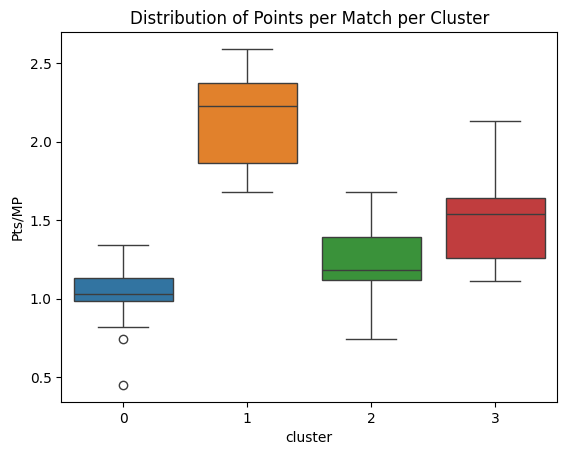

In [51]:

palette_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Reemplaza con los colores exactos que desees
sns.boxplot(data=dfModel, x='cluster', y='Pts/MP', palette=palette_colors)
plt.title('Distribution of Points per Match per Cluster')


In [52]:
dfModel.groupby('cluster')['Pts/MP'].mean()

cluster
0    1.035556
1    2.145833
2    1.237895
3    1.499000
Name: Pts/MP, dtype: float64